In [2]:
import h5py
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm

In [3]:
#importing the electron and photon datasets
electrons_file = h5py.File('/kaggle/input/electron-photon/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
photons_file = h5py.File('/kaggle/input/electron-photon/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')

In [4]:
#Splitting the datasets into images and labels
electrons_X = electrons_file['X']
electrons_y = electrons_file['y']

photons_X = photons_file['X']
photons_y = photons_file['y']

In [5]:
# Converthing them to torch tensors
electrons_X_tensor = torch.tensor(electrons_X[:])
electrons_y_tensor = torch.tensor(electrons_y[:])

photons_X_tensor = torch.tensor(photons_X[:])
photons_y_tensor = torch.tensor(photons_y[:])

In [6]:
#Concatenating the images and labels into single tensors
X = torch.cat((electrons_X_tensor, photons_X_tensor), dim=0)
y = torch.cat((electrons_y_tensor, photons_y_tensor), dim=0)

In [7]:
#Shape of the image
X.shape

torch.Size([498000, 32, 32, 2])

In [8]:
# Changing the shape as to make it compatible with pytorch requirements
X = torch.transpose(X, 1, 3)

In [9]:
#Combining X and y into a single tensor dataset
dataset = TensorDataset(X, y)

In [10]:
#Determining the train and test size
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

In [12]:
#Dividing the dataset into train and test set
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [13]:
#Making traing and test dataloaders
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
#ResNet15 implementation :-
class Block(nn.Module):
  def __init__(self, input_channels, intermediate_channels, stride=1, identity_downsample=None):
    super().__init__()
    self.in_channels = input_channels
    self.intermediate_channels = intermediate_channels
    self.identity_downsample = identity_downsample
    self.expansion = 1

    self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                           out_channels = self.intermediate_channels,
                           kernel_size=3,
                           stride=1,
                           padding=1,
                           bias=False)
    self.bn1 = nn.BatchNorm2d(self.intermediate_channels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels = self.intermediate_channels,
                           out_channels = self.intermediate_channels*self.expansion,
                           kernel_size=3,
                           padding=1,
                           stride=stride,
                           bias=False
                           )
    self.bn2 = nn.BatchNorm2d(self.intermediate_channels*self.expansion)

  def forward(self, x):
    identity = x.clone()

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)

    if self.identity_downsample != None:
      identity = self.identity_downsample(identity)

    x += identity
    x = self.relu(x)
    return x

class ResNet(nn.Module):
  def __init__(self, block, img_channels, num_classes, layers):
    super().__init__()
    self.in_channels = 64

    self.conv1 = nn.Conv2d(in_channels=img_channels,
                           out_channels = 64,
                           kernel_size=7,
                           stride=2,
                           padding=3,
                           bias = False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(
        in_channels = 64,
        out_channels = 64,
        kernel_size = 1,
        stride = 1,
        padding = 0,
        bias = False
    )
    self.bn2 = nn.BatchNorm2d(64)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

    self.layer1 = self.make_layer(layers[0], Block, 64, 1)
    self.layer2 = self.make_layer(layers[1], Block, 128, 2)
    self.layer3 = self.make_layer(layers[2], Block, 256, 2)

    self.avg = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(256 * 1, num_classes)


  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    x = self.avg(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)

    return x

  def make_layer(self, num_residual_blocks, block, intermediate_channels, stride):
    blocks = []
    identity_downsample = None

    if stride != 1 or self.in_channels != intermediate_channels * 1:
      identity_downsample = nn.Sequential(
          nn.Conv2d(in_channels = self.in_channels,
                    out_channels = intermediate_channels * 1,
                    stride=stride,
                    kernel_size=1,
                    padding=0,
                    bias = False),
          nn.BatchNorm2d(intermediate_channels * 1)
      )
    blocks.append(block(self.in_channels, intermediate_channels, stride, identity_downsample))

    self.in_channels = intermediate_channels * 1

    for i in range(num_residual_blocks - 1):
      blocks.append(block(self.in_channels, intermediate_channels))

    return nn.Sequential(*blocks)

In [15]:
#The model below is of the following architecture:
#1. First a convultional layer with a kernel size of 7
#2. Then another conv. layer with kernel size of 1
#3. Then a maxpooling layer
#4. Each block consists of 2 conv. layers and there are a total of 6 blocks.
#5. Hence a total of 15(1 + 1 + 1 + 6 * 2) layers which includes conv. layers and maxpool layers
model = ResNet(Block, 2, 1, [2, 2, 2])

In [16]:
#Setting the device
device = "cuda" if torch.cuda.is_available else 'cpu'

In [17]:
#Transferring the model to device
model.to(device)

ResNet(
  (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [18]:
#Setting the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Defining training function
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    train_loss = 0.0
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    return train_loss / len(train_loader.dataset)

# Defining the evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    y_true = []
    y_scores = []
    with torch.inference_mode():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            y_true.extend(targets.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())
    return roc_auc_score(y_true, y_scores)

### Logic for early stopping:
The code checks the validation performance (in this case, ROC-AUC score) after each epoch and tracks the performance over time. If the performance does not improve for a certain number of epochs (max_monotonic_increase), indicating a monotonic increase in the validation loss, or if it surpasses a tolerance threshold and does not improve for a certain number of epochs (max_gradual_increase), training is stopped early.


In [22]:
# Setting maximum patience for early stopping
max_monotonic_increase = 10
max_gradual_increase = 10

# Initializing the variables for early stopping and plotting
current_mono = 0
current_tolerance = 0
tolerance = float('inf')
# Initializing the best-auc variable
best_auc = 0.0

In [23]:
epochs = 20
# Training loop
for epoch in range(1, epochs + 1):
    print("Epoch {}/{}".format(epoch, epochs))
    train_loss = train(model, criterion, optimizer, train_dataloader, device)
    test_auc = evaluate(model, test_dataloader, device)
    
    print("Train Loss: {:.4f}, Test ROC-AUC: {:.4f}".format(train_loss, test_auc))
    
    # Update patience and tolerance
    if test_auc <= tolerance:
        current_tolerance += 1
    else:
        current_tolerance = 0
        tolerance = test_auc
    
    if current_tolerance == max_gradual_increase:
        print("Early stopping training due to overfitting...")
        break
     # Saving checkpoint
    if test_auc > best_auc:
        best_auc = test_auc
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
        print("Saving model checkpoint...")
    
    # Updating patience for early stopping
    if test_auc <= best_auc:
        current_mono += 1
    else:
        current_mono = 0
    
    if current_mono == max_monotonic_increase:
        print("Early stopping training due to overfitting...")
        break

print("Training completed!")

Epoch 1/20


  0%|          | 0/3113 [00:00<?, ?it/s]

Train Loss: 0.5548, Test ROC-AUC: 0.7887
Saving model checkpoint...
Epoch 2/20


  0%|          | 0/3113 [00:00<?, ?it/s]

Train Loss: 0.5513, Test ROC-AUC: 0.7885
Epoch 3/20


  0%|          | 0/3113 [00:00<?, ?it/s]

Train Loss: 0.5484, Test ROC-AUC: 0.7897
Saving model checkpoint...
Epoch 4/20


  0%|          | 0/3113 [00:00<?, ?it/s]

Train Loss: 0.5452, Test ROC-AUC: 0.7914
Saving model checkpoint...
Epoch 5/20


  0%|          | 0/3113 [00:00<?, ?it/s]

Train Loss: 0.5428, Test ROC-AUC: 0.7937
Saving model checkpoint...
Epoch 6/20


  0%|          | 0/3113 [00:00<?, ?it/s]

Train Loss: 0.5397, Test ROC-AUC: 0.7926
Epoch 7/20


  0%|          | 0/3113 [00:00<?, ?it/s]

Train Loss: 0.5368, Test ROC-AUC: 0.7945
Saving model checkpoint...
Epoch 8/20


  0%|          | 0/3113 [00:00<?, ?it/s]

Train Loss: 0.5340, Test ROC-AUC: 0.7921
Epoch 9/20


  0%|          | 0/3113 [00:00<?, ?it/s]

Train Loss: 0.5308, Test ROC-AUC: 0.7917
Epoch 10/20


  0%|          | 0/3113 [00:00<?, ?it/s]

Train Loss: 0.5273, Test ROC-AUC: 0.7925
Early stopping training due to overfitting...
Training completed!


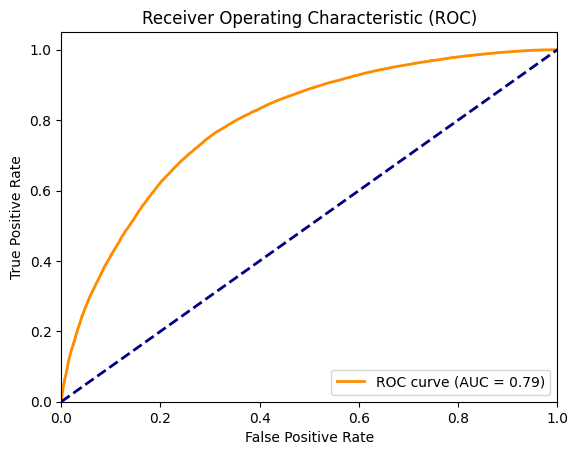

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Evaluating the best model on test data
best_model = ResNet(Block, 2, 1, [2, 2, 2]).to(device)
best_model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
y_true = []
y_scores = []
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = best_model(inputs)
        y_true.extend(targets.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())

# Calculating ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [25]:
#Model weights
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.7041,  0.2576,  0.0749,  ..., -0.6531, -0.1880, -0.5367],
                        [ 0.6931, -0.0556,  0.3573,  ...,  0.0131, -0.1520,  0.0090],
                        [ 0.1453,  0.2114, -0.0401,  ...,  0.1847,  0.1799, -0.4846],
                        ...,
                        [-0.1531, -0.4277,  0.2416,  ..., -0.7797, -0.0217,  0.7188],
                        [ 1.0999,  1.0475,  0.9523,  ..., -0.3269, -0.5014, -0.5402],
                        [ 0.0831,  0.0215,  0.7343,  ..., -0.4612, -0.3391, -1.1380]],
              
                       [[-0.0246,  0.0965, -0.0391,  ...,  0.1091, -0.2653, -0.2248],
                        [-0.3413,  0.0225,  0.0254,  ..., -0.0019, -0.0630,  0.0857],
                        [-0.1245, -0.3763,  0.1498,  ...,  0.0483,  0.0060,  0.1022],
                        ...,
                        [-0.0192,  0.2847, -0.1571,  ..., -0.1285, -0.3833,  0.2029],
                        [ 0.0492,  0